In [ ]:
#Importing libraries
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
import math



I would start by creating a code that has clear sections that separate what are the physical variables of the problem and what are the modelling choices


In [ ]:
#Physical parameters
L_in_cm = 50 #Length in cm of the 2D pool you are modeling
D_in_cm = 5 #Depth in cm of the pool you are modeling
#See these are the physical dimension of the object you are modeling and they
#are not going to change unless we model another system.




In [ ]:
#Non-dimensionalization
Unit_length_in_cm = 5

In [ ]:
#Numerical constants
nx = 500 #number of partitions of the domain in the x direction
nz = 50 #number of partition of the domain in the z direction

In [ ]:
#Dimensionless parameters
L = L_in_cm/Unit_length_in_cm
D = D_in_cm/Unit_length_in_cm

I would then put in a separate section the constants that are not chosen, but rather a direct consequence of the choices we made above.

In [ ]:
#Derived numerical constants
delta_x = L/nx
delta_z = D/nz
alpha = (delta_z/delta_x)**2

/tmp/ipython-input-926919922.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


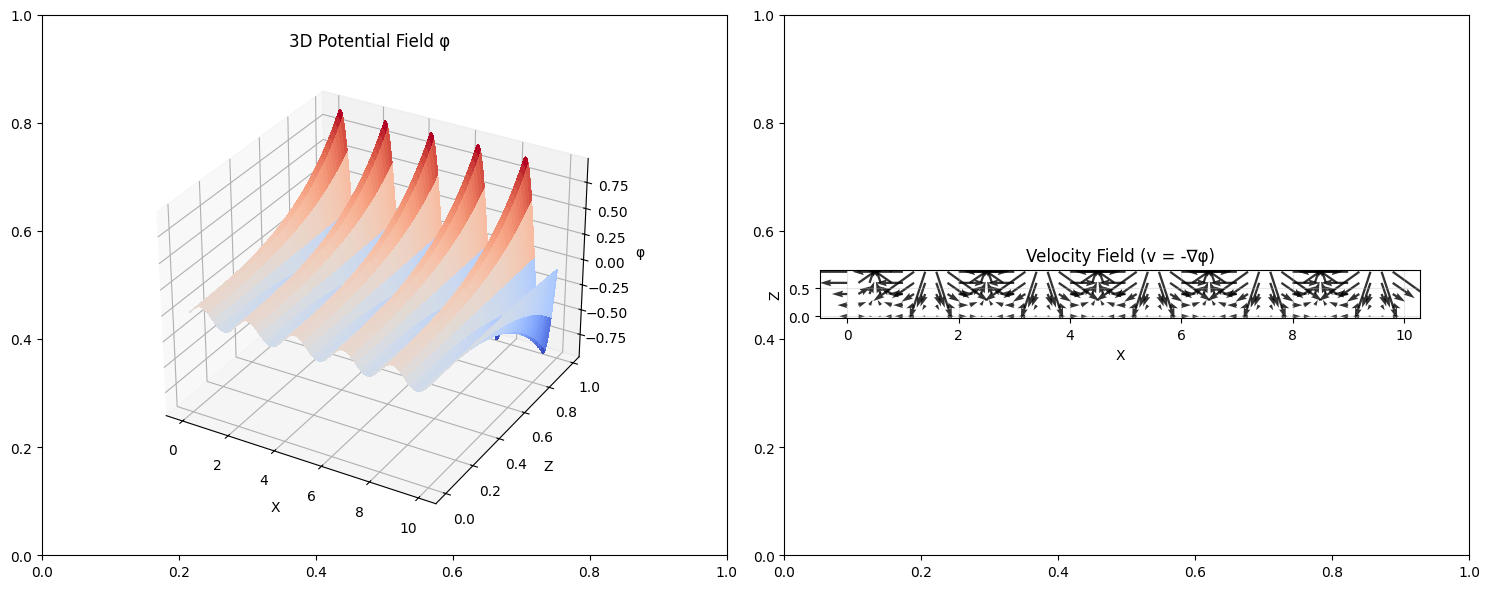

In [ ]:
phi = np.zeros((nz, nx)) #Store results

num_unknowns = nz*nx #I changed this to nz*nx

A = lil_matrix((num_unknowns, num_unknowns))

b = np.zeros(num_unknowns)

def to_1d_index(i, j):
    return i * nx + j # I changed this to make both numberings based on 0
def to_2d_index(idx):
    i = idx // nx # I changed this to make both numberings based on 0
    j = idx % nx
    return i, j

def Dirichlet_cond_top(x):
  return np.sin(2*math.pi*5*x/L) #np.exp(-(x-L/2)**2/(L/5)**2)

coeff_center = -2.0*alpha - 2.0
for i in range(nz):  # I changed this to number from the bottom
    for j in range(nx):  # all columns
        eq_idx = to_1d_index(i, j)

        #Inserting contribution from the same node
        A[eq_idx, eq_idx] = coeff_center

        #Inserting contribution from the node on the right
        if j < (nx-1):
            neighbor_idx = to_1d_index(i, j+1)
        else:
            neighbor_idx = to_1d_index(i, 0)
        A[eq_idx, neighbor_idx] = alpha

        #Inserting contribution from node on the left
        if j > 0:
            neighbor_idx = to_1d_index(i, j-1)
        else:
            neighbor_idx = to_1d_index(i, nx-1)
        A[eq_idx, neighbor_idx] = alpha

        #Inserting contribution from node at the top (be sure to introduce this one before the bottom one)
        if i < (nz-1):
          A[eq_idx, eq_idx+nx] = 1
        else:
          b[eq_idx] = -1*Dirichlet_cond_top(j*delta_x)

        #Inserting contribution from node at the bottom
        if i > 0:
            neighbor_idx = to_1d_index(i-1, j)
            A[eq_idx, neighbor_idx] = 1.0
        else:
            A[eq_idx, eq_idx+nx] = 2
# #Printing system of equations
# print("Matrix A:")
# print(A.toarray())
# print()
# print(f"Right-hand side vector b: {b}")

#Solving
vec = spsolve(A.tocsr(), b)

#Loading matrix of results
for idx in range(num_unknowns):
    i, j = to_2d_index(idx)
    phi[i, j] = vec[idx]

u = np.zeros((nz, nx)) #horizontal componenet
w = np.zeros((nz,nx)) #vertical component

for i in range(nz):
  for j in range(nx):
    if j == 0: #left boundary
      u[i,j] = -(phi[i,1] - phi[i, nx - 1])/(2 * delta_x)
    elif j == nx-1: #right boundary
      u[i,j] = -(phi[i,0] - phi[i,nx-2])/(2*delta_x)
    else: #interior point
      u[i,j] = (phi[i,j+1] - phi[i,j-1])/(2*delta_x)

for i in range(nz):
  for j in range(nx):
    if i == 0: #bottom boundary
      w[i,j] = -(phi[i + 1,j] - phi[i,j])/(delta_z) #only one neighboring point so only delta_z
    elif i == nz-1: #top boundary
      w[i,j] = -(phi[i,j] - phi[i-1,j])/(delta_z) #same here
    else: #interior point
      w[i,j] = (phi[i+1,j] - phi[i-1,j])/(2*delta_z)

#I asked AI to plot this for me as I am in a rush this morning! Will clean up when I get back!
#____________________________________
#Plotting results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create coordinate arrays
x_vec = np.array([ind*delta_x for ind in range(nx)])
z_vec = np.array([ind*delta_z for ind in range(nz)])
X_mat, Z_mat = np.meshgrid(x_vec, z_vec)

# Plot 1: 3D Potential field φ surface (like your original)
ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.8], projection='3d')
surf = ax1.plot_surface(X_mat, Z_mat, phi, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('φ')
ax1.set_title('3D Potential Field φ')

# Plot 2: Velocity field as arrows
ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.8])
# Subsample for better visualization
skip = 10  # plot every 10th arrow
X_sub = X_mat[::skip, ::skip]
Z_sub = Z_mat[::skip, ::skip]
U_sub = u[::skip, ::skip]
W_sub = w[::skip, ::skip]

ax2.quiver(X_sub, Z_sub, U_sub, W_sub, scale=20, alpha=0.8)
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_title('Velocity Field (v = -∇φ)')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()